In [11]:
import json
import sys
import os
import matplotlib.pyplot as plt 
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../src')))

import json
import wfqc.network as nw
from scipy.stats import ttest_rel
import numpy as np 
from wfqc.metrics import get_graph_edge_weight


import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error



In [ ]:
"""

Proposed structure

  A B C
A c* 1 3
B 1 c* 2
C 3 2  c*

symmetrical: only store half
Self connection contains node information



"""

In [5]:
with open('../out_202407041439/train_rated.json', 'r') as f:
    rated_workflows = json.load(f)

In [31]:
with open('../out_202407041439/edgestopic_0121.json', 'r') as f:
    citation_data = json.load(f)

citation_counts = {tool['pmid']: tool['nrCitations'] for tool in citation_data['tools']}

In [35]:
with open('../../tool_metadata_topic_0121_20240703.json', "r") as f: # as generated by create_citation_network
    metadata_file = json.load(f)

tool_ages = {tool['pmid']:tool['pubDate'] for tool in metadata_file['tools']}

In [14]:
graph = nw.create_citation_network(inpath='../out_202407041439')


Loading saved data.


In [6]:
def convert_to_tuples(list_of_lists):
    """
    Converts a list of lists into a list of tuples.

    :param list_of_lists: List of lists to be converted.
    :return: List of tuples.
    """
    return [tuple(inner_list) for inner_list in list_of_lists]



In [7]:
highly_rated_workflows = [workflow["pmid_workflow"] for workflow in rated_workflows if workflow['ratingAvg'] >= 2] # this means that at least one of them gave it a two or higher
highly_rated_workflows = [convert_to_tuples(workflow) for workflow in highly_rated_workflows]

In [24]:
print(len(highly_rated_workflows))

50


filtering so we only have not none edges

In [25]:
notnone_highly_rated_workflows = []

for workflow in highly_rated_workflows:
    tools = {pmid for tup in workflow for pmid in tup} # collect what tools are in the workflow, ignoring Nones
    if not None in tools:
        notnone_highly_rated_workflows.append(workflow)

In [26]:
print(len(notnone_highly_rated_workflows))

40


In [36]:
#testing for one
for edge in notnone_highly_rated_workflows[0]:
    print(edge)
    print(get_graph_edge_weight(graph, edge))
    print(citation_counts[edge[0]], citation_counts[edge[1]])
    print(tool_ages[edge[0]], tool_ages[edge[1]])

('23051804', '23148064')
101.0
1510 718
None 2013 Jan
('23148064', '12403597')
181.0
718 3040
2013 Jan 2002 Oct 15
('12403597', '14632076')
1919.0
3040 2955
2002 Oct 15 None


In [88]:
def nr_tools(workflow, include_none = False):
    tools = set()
    if include_none:
        tools = {pmid for tup in workflow for pmid in tup if pmid is not None}
        return tools 
    else:
        tools = list({pmid for tup in workflow for pmid in tup})
        return tools

In [150]:
max_edges = 4
#max_nodes = 5 # should be defined by the max nr of nodes in the dataset 


def generate_matrix_workflow(workflow, max_nodes, graph, citation_counts, tool_ages):
    matrix = np.zeros((2, max_nodes, max_nodes))

    tools = list({pmid for tup in workflow for pmid in tup})


    for i in range(max_nodes):
        if i >= len(tools) - 1:
            break 
        for j in range(i+1):
            if j >= len(tools) - 1:
                break 
            if i==j:
                
                matrix[0, i, j] = citation_counts[ tools[i] ] # citations
                age = tool_ages[ tools[i] ] or 2000
                matrix[1, i, j] = str(age).split(' ')[0] # ages 
            else: 
                matrix[0, i, j] = get_graph_edge_weight( graph, ( tools[i], tools[j] ))
    
    return matrix


def create_matrix_dataset(workflow_dict, graph, citation_counts, tool_ages):

    labels = np.zeros((len(workflow_dict)))  
    matrix_dataset = list(np.zeros((len(workflow_dict))))

    # Calculate largest nr tools in dataset:
    workflows = [workflow["pmid_workflow"] for workflow in workflow_dict] # this means that at least one of them gave it a two or higher
    max_nodes = max([ len(nr_tools(workflow)) for workflow in workflows]) # this can not handle emply 
    
    for i, workflow in enumerate(workflow_dict): 
        # Get the rating of the workflow
        labels[i] = workflow["ratingAvg"] 
        # Make matrix representation of the workflow (converted to tuples so it works with the metrics)
        matrix_dataset[i] = generate_matrix_workflow( convert_to_tuples(workflow["pmid_workflow"]) , max_nodes, graph, citation_counts, tool_ages)

    return labels, matrix_dataset


In [151]:
def not_none_workflows(workflows, type_ = dict):
    notnone_workflows = []
    
    if type_ == list:
        for workflow in workflows:
            tools = {pmid for tup in workflow for pmid in tup} # collect what tools are in the workflow, ignoring Nones
            if not None in tools:
                notnone_workflows.append(workflow)
                
        return notnone_workflows
    elif type_ == dict: 
        print("Assuming dictionary follows citation data file format.") # maybe spec what that is 
        for workflow in workflows:
            tools = {pmid for tup in convert_to_tuples(workflow['pmid_workflow']) for pmid in tup} # collect what tools are in the workflow, ignoring Nones
            if not None in tools:
                notnone_workflows.append(workflow)
                
        return notnone_workflows

In [152]:
workflow_dict = not_none_workflows(rated_workflows)
print(len(workflow_dict))
labels, matrix_dataset = create_matrix_dataset(workflow_dict, graph, citation_counts, tool_ages)

Assuming dictionary follows citation data file format.
217


In [153]:
print(labels[0], matrix_dataset[0])

0.5 [[[2955.    0.    0.    0.    0.    0.]
  [1919. 3040.    0.    0.    0.    0.]
  [  92.  181.  718.    0.    0.    0.]
  [   0.    0.    0.    0.    0.    0.]
  [   0.    0.    0.    0.    0.    0.]
  [   0.    0.    0.    0.    0.    0.]]

 [[2000.    0.    0.    0.    0.    0.]
  [   0. 2002.    0.    0.    0.    0.]
  [   0.    0. 2013.    0.    0.    0.]
  [   0.    0.    0.    0.    0.    0.]
  [   0.    0.    0.    0.    0.    0.]
  [   0.    0.    0.    0.    0.    0.]]]


perhaps remove obs where age is not given, or add year 2000 if there is no age in the database bacause right now there is a big difference. 

ALMA, use ages instead gosh !!

I want an interpretable ML model

In [155]:
X = [matrix.flatten() for matrix in matrix_dataset]
y = labels

X = np.array(X)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Mean Squared Error: 0.69


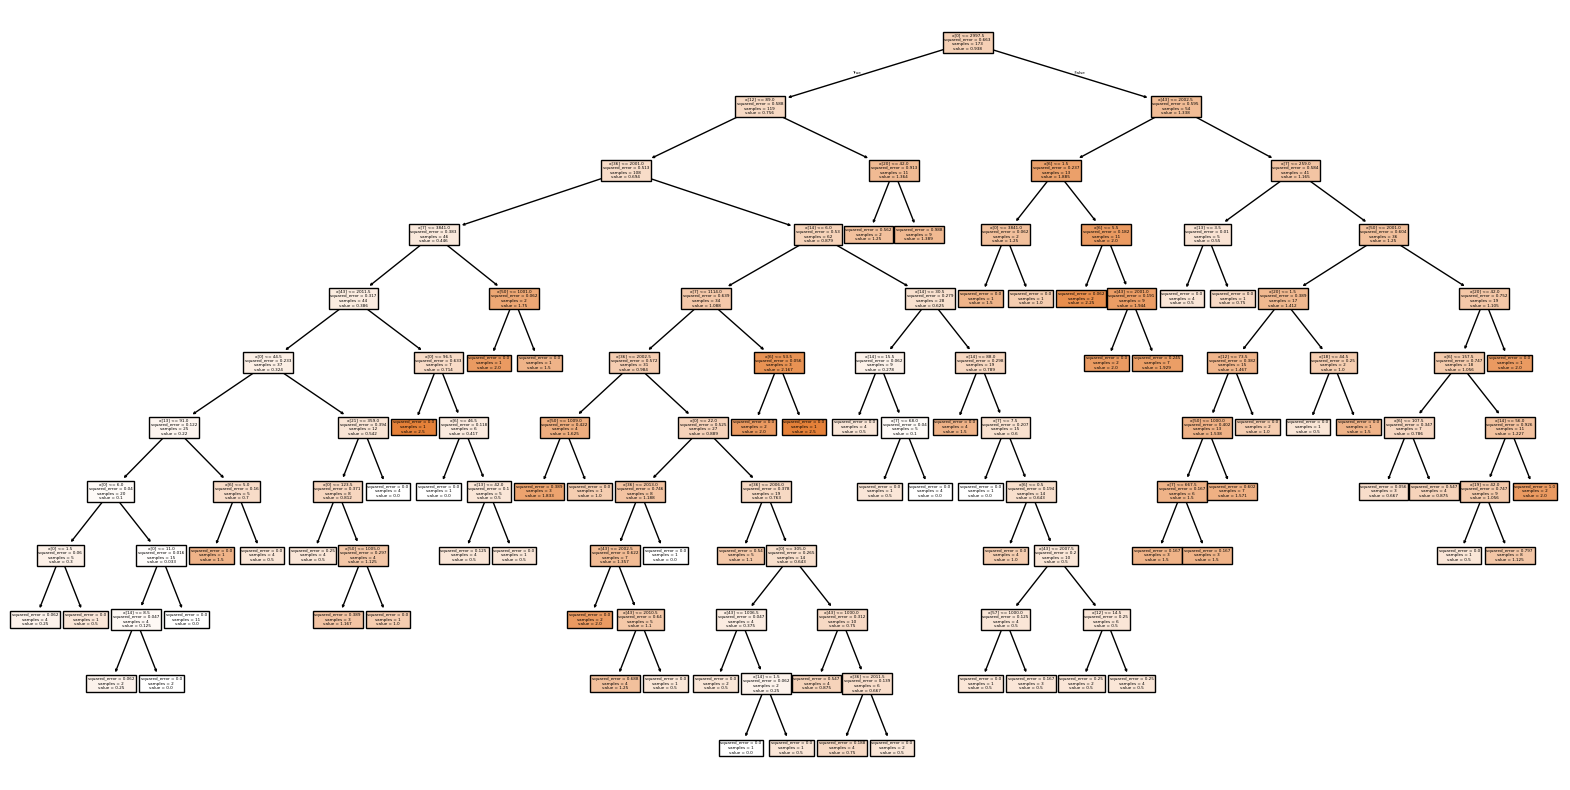

Spearman correlation coefficient between original and predicted ratings: 0.48


In [161]:



model = DecisionTreeRegressor()
model.fit(X_train, y_train)


y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse:.2f}')

from sklearn import tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
tree.plot_tree(model, filled=True)
plt.show()

from scipy.stats import spearmanr

correlation, _ = spearmanr(y_test, y_pred)

print(f'Spearman correlation coefficient between original and predicted ratings: {correlation:.2f}')


Mean Squared Error: 0.46


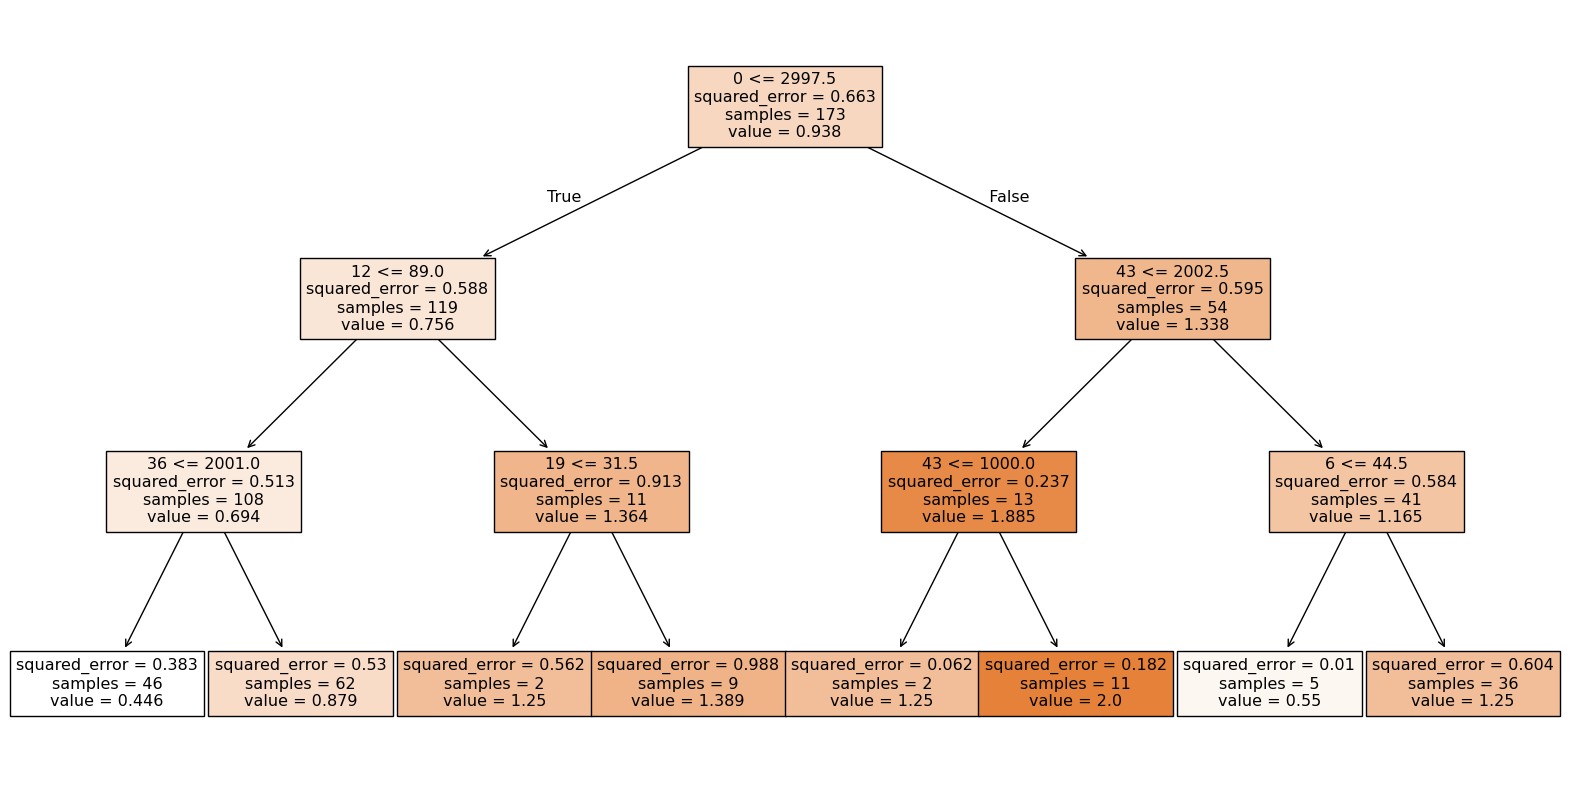

Spearman correlation coefficient between original and predicted ratings: 0.46


In [158]:
#too big. making smaller

model = DecisionTreeRegressor(max_depth=3)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse:.2f}')

plt.figure(figsize=(20, 10))
plot_tree(model, filled=True, feature_names=feature_names)
plt.show()

from scipy.stats import spearmanr

correlation, _ = spearmanr(y_test, y_pred)

print(f'Spearman correlation coefficient between original and predicted ratings: {correlation:.2f}')


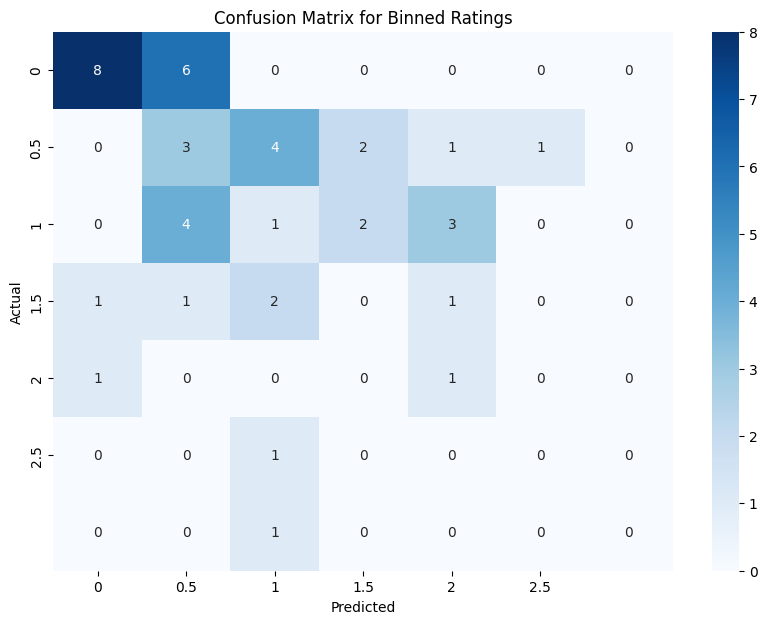

In [159]:

model = DecisionTreeRegressor()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

bins = [0, 0.5, 1, 1.5, 2, 2.5, 3]
y_test_binned = np.digitize(y_test, bins) - 1
y_pred_binned = np.digitize(y_pred, bins) - 1

conf_matrix = confusion_matrix(y_test_binned, y_pred_binned)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=bins[:-1], yticklabels=bins[:-1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Binned Ratings')
plt.show()

In [127]:
from scipy.stats import spearmanr

correlation, _ = spearmanr(y_test, y_pred)

print(f'Spearman correlation coefficient between original and predicted ratings: {correlation:.2f}')


Pearson correlation coefficient between original and predicted ratings: 0.49


In [129]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    correlation, _ = spearmanr(y_test, y_pred)
    return mse, correlation

models = {
    "Linear Regression": LinearRegression(),
    "Random Forest Regressor": RandomForestRegressor(),
    "Support Vector Regressor": SVR()
}

results = {}
for name, model in models.items():
    mse, correlation = evaluate_model(model, X_train, X_test, y_train, y_test)
    results[name] = {
        "Mean Squared Error": mse,
        "Pearson Correlation": correlation
    }

for name, metrics in results.items():
    print(f"{name}:\n - Mean Squared Error: {metrics['Mean Squared Error']:.2f}\n - Spearman Correlation: {metrics['Pearson Correlation']:.2f}\n")


Linear Regression:
 - Mean Squared Error: 0.54
 - Spearman Correlation: 0.37

Random Forest Regressor:
 - Mean Squared Error: 0.46
 - Spearman Correlation: 0.62

Support Vector Regressor:
 - Mean Squared Error: 0.48
 - Spearman Correlation: 0.39



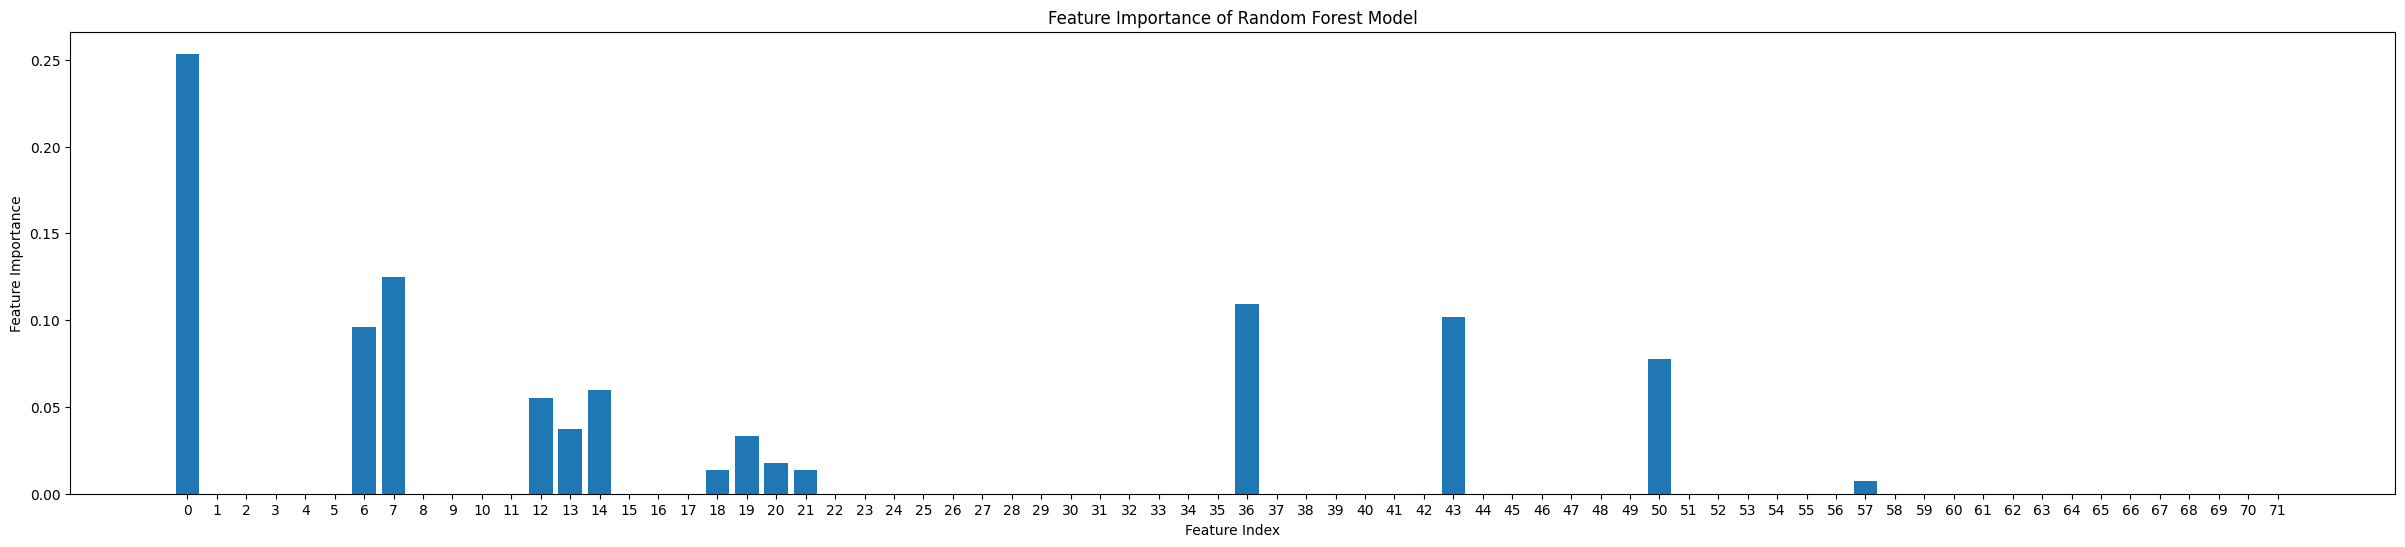

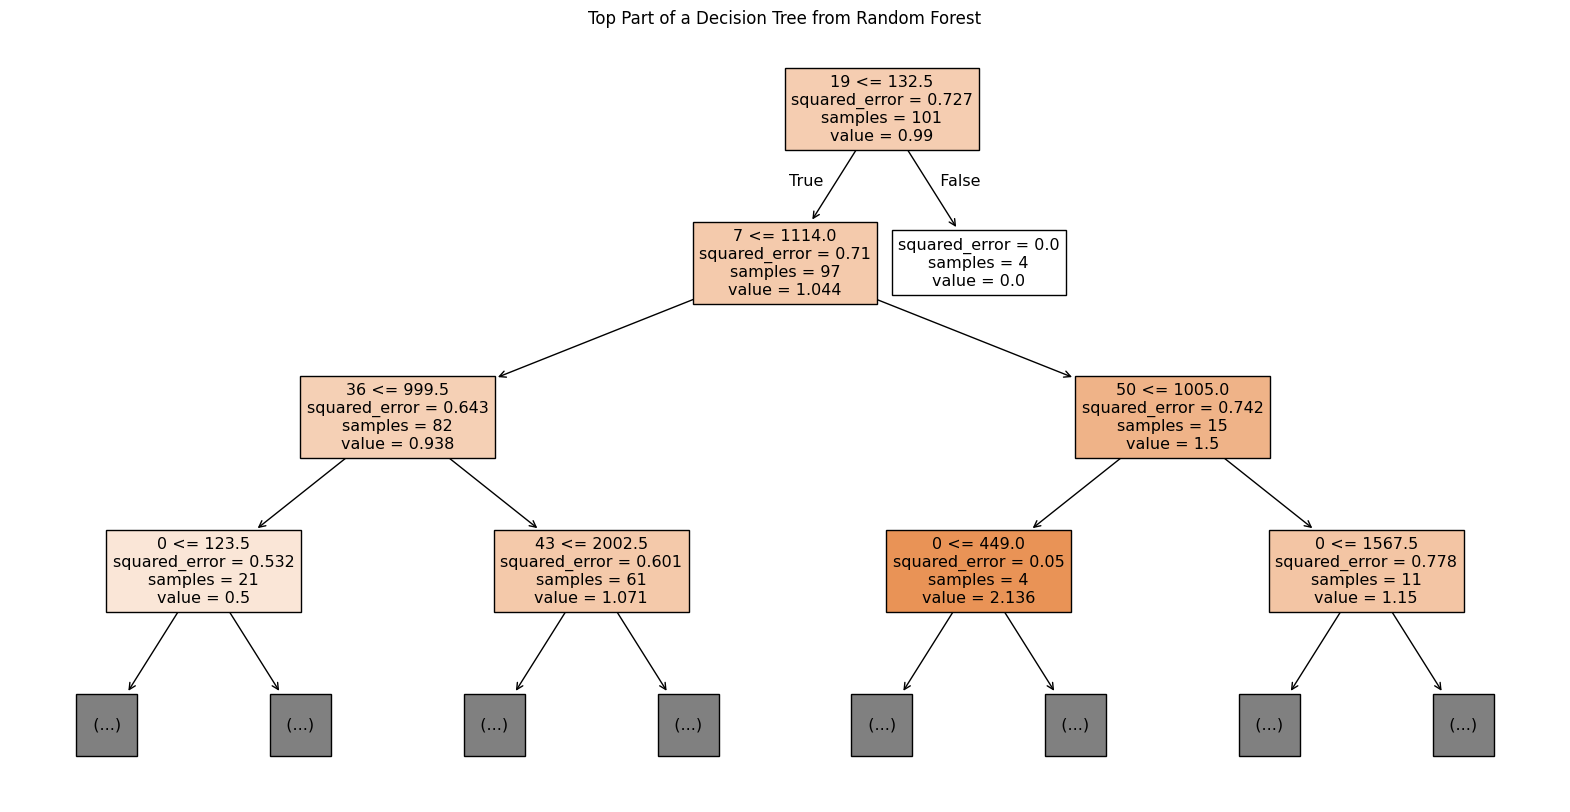

In [149]:
model = RandomForestRegressor()
model.fit(X_train, y_train)

# Checking feature importance
feature_importance = model.feature_importances_
feature_names = np.arange(len(feature_importance))  # feature names are not available
sorted_idx = np.argsort(feature_importance)[::-1]
sorted_feature_importance = feature_importance[sorted_idx]
sorted_feature_names = feature_names[sorted_idx]

# Plot feature importance
plt.figure(figsize=(30, 6))
plt.bar(sorted_feature_names, sorted_feature_importance, align='center')
plt.xticks(sorted_feature_names)
plt.xlabel('Feature Index')
plt.ylabel('Feature Importance')
plt.title('Feature Importance of Random Forest Model')
plt.show()

# top part of a single decision tree
plt.figure(figsize=(20, 10))
plot_tree(model.estimators_[0], max_depth=3, filled=True, feature_names=feature_names)
plt.title('Top Part of a Decision Tree from Random Forest')
plt.show()


Can continue by:

testing of the APE dataset, and on the broken wf dataset - want it to be good for all datasets - combine datasets or what to do? give different ratings/weightd.
Create a more broken dataset? step by step breaking it more. 

choosing to keep different information about the workflows, and changing how they are represented - not flattening for ex? 

other values, like medains, metric scores etc and see if it is used? 

what should it fulfill? have good correlation with rated? detect good bad workflows/ broken edges? 



should all be as important? 
combining different metrics. one good at id bad workflows for ex